In [1]:
""" Mount Google Drive to Google Colab Notebook
""" 
from google.colab import drive
drive.mount('/content/drive')
""" Change present working directory
"""
%cd /content/drive/MyDrive/CS5260

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS5260


In [2]:
!ls

archive
dataset_flickr8k.json
meta_Arts_Crafts_and_Sewing.json.gz
meta_Office_Products.json.gz
meta_Tools_and_Home_Improvement.json.gz
TEST_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json
TEST_CAPTIONS_flickr8k_5_cap_per_img_5_min_word_freq.json
TEST_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5
TRAIN_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json
TRAIN_CAPTIONS_flickr8k_5_cap_per_img_5_min_word_freq.json
TRAIN_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5
VAL_CAPLENS_flickr8k_5_cap_per_img_5_min_word_freq.json
VAL_CAPTIONS_flickr8k_5_cap_per_img_5_min_word_freq.json
VAL_IMAGES_flickr8k_5_cap_per_img_5_min_word_freq.hdf5
WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json


<hr>
<h1>Import dependencies and define helper functions</h1>

In [3]:
import pandas as pd
import gzip
import json
import re
import string
import random
import skimage.io as io
import matplotlib.pyplot as plt

In [4]:
# Cleaner helper function
CLEANR = re.compile('<.*?>') 

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

# Import the data gz and convert to pandas DF
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_raw = getDF('meta_Office_Products.json.gz')

In [5]:
## FOR TESTING ONLY
df_raw = df_raw[:1000]

In [6]:
# Number of rows with imageURLHighRes == num of rows with imageURL i.e., if missing imageURLHighRes
# then also missing imageURL, therefore no picture at all
print(len(df_raw['imageURLHighRes'].apply(lambda a: len(a) > 0)))
print(len(df_raw['imageURL'].apply(lambda a: len(a) > 0)))

1000
1000


<hr>
<h1>Filter and clean the data to include only columns of interest</h1>

In [7]:
# Filter the df to include only 4 required columns and remove rows with no image or title
df_filtered = df_raw[['title', 'brand', 'description', 'imageURLHighRes']]
df_filtered = df_filtered[df_filtered['imageURLHighRes'].apply(lambda r: len(r) > 0)].reset_index(drop=True)
df_filtered = df_filtered[df_filtered['title'].apply(lambda x: len(x) > 0)].reset_index(drop=True)

# Update imageURLHighRes column to include only first image
df_filtered['imageURLHighRes'] = df_filtered['imageURLHighRes'].apply(lambda r: r[0])

In [8]:
# Show filtered df
df_filtered.head()

,title,brand,description,imageURLHighRes
0,EKLOEN Mixed Designs of Antiqued Bronze Colour...,EKLOEN,[A good helper to help you record your reading...,https://images-na.ssl-images-amazon.com/images...
1,1977 J.R.R. TOLKIEN CALENDAR,Ballantine,[1977 J.R.R. Tolkien Calendar with illustrated...,https://images-na.ssl-images-amazon.com/images...
2,Jzcky Shzrp Unique Appearance Premium Quality ...,Jzcky Shzrp,[Unique DesignNovel Appearance<br> Electroplat...,https://images-na.ssl-images-amazon.com/images...
3,Jzcky Shzrp Classic Attachable Key Chain -Supe...,Jzcky Shzrp,[Please avoid the friction with other metal or...,https://images-na.ssl-images-amazon.com/images...
4,Webster's II New Riverside Dictionary-Revised ...,Houghton Mifflin,"[Websters II Dictionary, Office Edition Third ...",https://images-na.ssl-images-amazon.com/images...


In [9]:
# Remove the text from brand column from title column
df_filtered['title'] = df_filtered[['title', 'brand']].apply(lambda x: x['title'].replace(x['brand'], ""), axis=1)

# Join the elements in description array
df_filtered['description'] = df_filtered['description'].apply(lambda x: " ".join(x))

# Drop the brand column as no longer needed
df_filtered = df_filtered.drop('brand', axis=1)

In [10]:
# Remove HTML markup elements from description
df_filtered['description'] = df_filtered['description'].apply(lambda x: cleanhtml(x))

In [11]:
# Show df
df_filtered.head()

,title,description,imageURLHighRes
0,Mixed Designs of Antiqued Bronze Colour Elega...,A good helper to help you record your reading ...,https://images-na.ssl-images-amazon.com/images...
1,1977 J.R.R. TOLKIEN CALENDAR,1977 J.R.R. Tolkien Calendar with illustrated ...,https://images-na.ssl-images-amazon.com/images...
2,Unique Appearance Premium Quality Car Key Cha...,Unique DesignNovel Appearance Electroplating p...,https://images-na.ssl-images-amazon.com/images...
3,Classic Attachable Key Chain -Super Elastic S...,Please avoid the friction with other metal or ...,https://images-na.ssl-images-amazon.com/images...
4,Webster's II New Riverside Dictionary-Revised ...,"Websters II Dictionary, Office Edition Third E...",https://images-na.ssl-images-amazon.com/images...


In [12]:
# Check how many rows have descriptions
num_rows_total = len(df_filtered)
num_rows_with_desc = len(df_filtered[df_filtered['description'].apply(lambda x: len(x) > 0)])
print(f'Total: {num_rows_total} rows, {num_rows_with_desc} with description. {num_rows_with_desc/num_rows_total:.2f}%')

Total: 616 rows, 540 with description. 0.88%


<hr>
<h1>Show 5 random products with description and picture</h1>

 Teacher's Friend Math Class Quiz: Grades 2-4 Pocket Chart Add-ons, Multiple Colors (TF5411)
For use with your Scholastic Class Quiz Pocket Chart


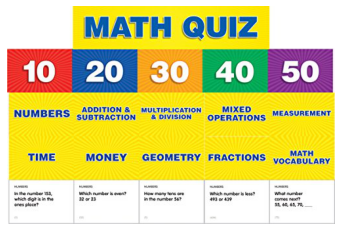


2017 Weekly Vinyl Puffy Owl Engagement Calendar Planner



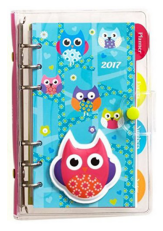


 Cats at Play Gift Notes, Multi-color (30672)
The perfect enclosure card for any gift. Full coloer, die cut cards and color coordinated envelopes will make your present look extra special!


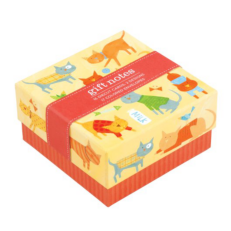


Jesus and the Children Attendance Chart in Tube
Perfect for organizing information in visual form, this attendance chart includes ruled lines for easy writing, with space for 48 names with 14 squares opposite each. "Roll of Attendance" is at the top with full-color art depiction of "Jesus and the Children" and sheep down the left side of the chart; 31" x 15", Mylar reinforced and safely shipped in a mailing tube to protect and prevent creases.  To examine other available Attendace Charts  Keyword Search: Attendance Charts and click Search.


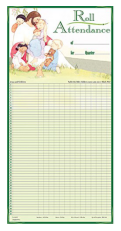


Graphic Stars Printer Paper (TF3569)
Colorful printer paper that can be used as awards, invitations, notes to parents, classroom newsletters, and more. Two writing templates are includedone for the primary grades and one for the upper grades.


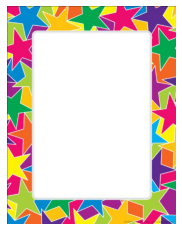

In [13]:
for _ in range(5):
  idx = random.randint(0, num_rows_total)
  print(df_filtered['title'][idx])
  print(df_filtered['description'][idx])
  I = io.imread(df_filtered['imageURLHighRes'][idx])
  plt.axis('off')
  plt.imshow(I)
  plt.show()
  print()

In [14]:
!pwd

/content/drive/MyDrive/CS5260


<hr>
<h1>Data Loader</h1>

In [15]:
# Use only those rows with sufficiently long description
MIN_LEN = 5 # Set minimum num of characters in description
df_labelled = df_filtered[df_filtered['description'].apply(lambda x: len(x) > MIN_LEN)].reset_index(drop=True)
print(f'There are {len(df_labelled)} products')

There are 532 products


In [16]:
# Describe the length of each description
token_lens = (df_labelled['description'].apply(lambda x: len(x.split())))
print(token_lens.describe())
# Use 90th percentile length as max 
perc_90 = token_lens.quantile(q=0.9)

count    532.000000
mean      47.731203
std       44.737876
min        2.000000
25%       17.000000
50%       36.000000
75%       61.000000
max      313.000000
Name: description, dtype: float64


In [17]:
import nltk
nltk.download('punkt')
from sklearn.preprocessing import OneHotEncoder

corpus = df_labelled['description'].to_list()
corpus = " ".join(corpus)
corpus = nltk.word_tokenize(corpus)

word_dict, idx = {}, 1
for w in corpus:
  if w not in word_dict:
    word_dict[w] = idx
    idx += 1

word_dict['<unk>'] = len(word_dict) + 1
word_dict['<start>'] = len(word_dict) + 1
word_dict['<end>'] = len(word_dict) + 1
word_dict['<pad>'] = 0

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
def string_to_vector(caption_str):
  caption_str = nltk.word_tokenize(caption_str)
  return [word_dict['<start>']] + [word_dict.get(word, word_dict['<unk>']) for word in caption_str] + [word_dict['<end>']] + [word_dict['<pad>']] * int(perc_90 - len(caption_str))

In [43]:
import torch
from torch.utils.data import Dataset
import h5py
import json
import os
from sklearn.model_selection import train_test_split
from PIL import Image

class CaptionDataset(Dataset):
    # Hijacked class to use own DF

    def __init__(self, _, __, split, transform=None):
        """
        :param data_folder: folder where data files are stored
        :param data_name: base name of processed datasets
        :param split: split, one of 'TRAIN', 'VAL', or 'TEST'
        :param transform: image transform pipeline
        """
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        train, test = train_test_split(df_labelled, test_size=0.2)

        if self.split is 'TRAIN':
          self.imgs = train['imageURLHighRes']
          self.captions = train['description']

        else:
          self.imgs = test['imageURLHighRes']
          self.captions = test['description']

        # PyTorch transformation pipeline for the image (normalizing, etc.)
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(df_labelled)

    def __getitem__(self, i):
        # Get image from URL
        print(i)
        img = io.imread(self.imgs[i])

        # if len(img.shape) == 2:
        #   img = img[:, :, np.newaxis]
        #   img = np.concatenate([img, img, img], axis=2)
        #   #img = imresize(img, (256, 256))
        img = np.array(Image.fromarray(img).resize([256, 256]))
        img = img.transpose(2, 0, 1)
        assert img.shape == (3, 256, 256)
        assert np.max(img) <= 255
        # print(img.shape)
        # if self.transform is not None:
        #     img = self.transform(img)

           

        caption = string_to_vector(self.captions[i])

        caplen = len(caption)

        if self.split is 'TRAIN':
            return img, caption, caplen
        else:
            return img, caption, caplen, caption

    def __len__(self):
        return self.dataset_size

<hr>
<h1>Training</h1>

In [44]:
import torch
from torch import nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.

        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.

        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.

        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).

        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [45]:
import os
import numpy as np
import h5py
import json
import torch
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample

def init_embedding(embeddings):
    """
    Fills embedding tensor with values from the uniform distribution.

    :param embeddings: embedding tensor
    """
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)


def load_embeddings(emb_file, word_map):
    """
    Creates an embedding tensor for the specified word map, for loading into the model.

    :param emb_file: file containing embeddings (stored in GloVe format)
    :param word_map: word map
    :return: embeddings in the same order as the words in the word map, dimension of embeddings
    """

    # Find embedding dimension
    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())

    # Create tensor to hold embeddings, initialize
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)

    # Read embedding file
    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')

        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))

        # Ignore word if not in train_vocab
        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim


def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.

    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, 'BEST_' + filename)


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.

    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [46]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

# Data parameters
data_folder = '/media/ssd/caption data'  # folder with data files saved by create_input_files.py
data_name = 'coco_5_cap_per_img_5_min_word_freq'  # base name shared by data files

# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Training parameters
start_epoch = 0
epochs = 120  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 100  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none


def main():
    """
    Training and validation.
    """

    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

    # Read word map
    word_map = word_dict

    # Initialize / load checkpoint
    if checkpoint is None:
        decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(word_map),
                                       dropout=dropout)
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
        encoder = Encoder()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['bleu-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                 lr=encoder_lr)

    # Move to GPU, if available
    decoder = decoder.to(device)
    encoder = encoder.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)

    # Custom dataloaders
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        # One epoch's training
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        # One epoch's validation
        recent_bleu4 = validate(val_loader=val_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion)

        # Check if there was an improvement
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)


def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.

    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))


def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.

    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4


if __name__ == '__main__':
    main()

127
434
471
479
519


KeyError: ignored

263


In [49]:
img = io.imread(df_labelled['imageURLHighRes'][479])
img = np.array(Image.fromarray(img).resize([256, 256]))
img = img.transpose(2, 0, 1)
img.shape

(3, 256, 256)